In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, IntegratedGradients, GradientShap

from functools import partial

from CustomCNNSegmentation import SimpleResNetSegmentation, SimpleResNetSegmentationWithoutBN

In [2]:
# Default device plus free memory
torch.cuda.empty_cache()
#device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Defined dataset
dataset_type = 'large'

# Path to save the plots
path = f"AttributionsMaps/Segmentation/DotInTheMiddle_WithBn/"


data = torch.load(f'./data/segmentation_custom_dataset/{dataset_type}_segmentation.pth')
images = data['images'].float() 
labels = data['labels'].float() 

# Create dataset
dataset = TensorDataset(images.unsqueeze(1), labels)  # Add channel dimension

# Instantiate the model
model = SimpleResNetSegmentation(num_classes=2).to(device)
#model = SimpleResNetSegmentationWithoutBN(num_classes=2).to(device)


# Load the weights
model.load_state_dict(torch.load(f"./Models/custom_cnn_segmentation_{dataset_type}.pth"))

#model.load_state_dict(torch.load(f"./Models/custom_cnn_segmentation_{dataset_type}_withoutbn.pth"))

model.eval()  # Set the model to evaluation mode

SimpleResNetSegmentation(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (resblock1): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

In [4]:
test_loader = DataLoader(dataset, batch_size=20, shuffle=False)

# Select a random batch from the test dataset
images, masks = next(iter(test_loader))

In [5]:
class SegmentationAttribution:
    def __init__(self, model, images, masks=None, device="cuda"):
        self.model = model.to(device)
        self.images = [img.to(device) for img in images]
        self.masks = masks
        self.device = device
        self.out_maxes = []
        self.centroids = []

    def apply_model(self):
        for img in self.images:
            input_tensor = img.unsqueeze(0)
            output = self.model(input_tensor)
            out_max = torch.argmax(output, dim=1, keepdim=True)
            self.out_maxes.append(out_max)

    def agg_segmentation_wrapper(self, inp, out_max):
        model_out = self.model(inp)
        selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
        return (model_out * selected_inds).sum(dim=(2,3))

    def pixels_wrapper(self, inp,):
        model_out = self.model(inp)
        return (model_out[0:1, :, self.p_height, self.p_width])

    def compute_attributions(self, method, layer, tgt, n_steps=10, baselines=None, wrapper_type="agg", p_height = 14, p_width = 14):
        method_instance = {
            'LayerGradCam': LayerGradCam,
            'LayerActivation': LayerActivation,
            'FeatureAblation': FeatureAblation,
            'IntegratedGradients': partial(IntegratedGradients, multiply_by_inputs=False),
            'GradientShap': GradientShap
        }[method]

        #self.centroids = []
        if method == "IntegratedGradients":
            self.model.eval()
            if baselines is None:
                baselines = torch.zeros_like(self.images[0].unsqueeze(0))

        attrs = []
        for idx, (img, out_max) in enumerate(zip(self.images, self.out_maxes)):
            input_tensor = img.unsqueeze(0)

            if wrapper_type == "agg":
                wrapper_func = lambda inp: self.agg_segmentation_wrapper(inp, out_max)
            elif wrapper_type == "pix":
                if self.masks is not None:
                    mask = self.masks[idx].to(self.device)
                    """ p_width, p_height = self.find_centroid(mask)
                    self.centroids.append((p_width, p_height)) """
                else:
                    raise ValueError("Pixel coordinates (p_height, p_width) must be provided either directly or through a mask.")
                """ self.p_height = int(p_height)
                self.p_width = int(p_width) """
                
                self.p_height = int(self.centroids[idx][0])
                self.p_width = int(self.centroids[idx][1])
                # Experimenting with black dot on the center
                input_tensor[:, :, p_height, p_width] = 0
                wrapper_func = self.pixels_wrapper
            else:
                raise ValueError("Invalid wrapper_type. Choose either 'agg' or 'pix'.")


            try:
                attr_method = method_instance(wrapper_func, layer)
            except:
                attr_method = method_instance(wrapper_func)
                

            if method == "FeatureAblation":
                attr = attr_method.attribute(input_tensor,
                                             feature_mask=out_max, 
                                             perturbations_per_eval=2, target=tgt)

            elif method == "IntegratedGradients":
                attr, _ = attr_method.attribute(input_tensor, 
                                                target=tgt, baselines=baselines, method='gausslegendre',
                                                return_convergence_delta=True, n_steps=n_steps)
                
            elif method == "LayerActivation":
                attr = attr_method.attribute(input_tensor)
                attr = attr[:, tgt, :, :].unsqueeze(0)

            elif method == "GradientShap":
                if baselines is None:
                    baselines = torch.zeros_like(self.images[0].unsqueeze(0))
                attr = attr_method.attribute(input_tensor, target=tgt, baselines=baselines)

            else:
                attr = attr_method.attribute(input_tensor, target=tgt)
                
            attrs.append(attr)
        return attrs

    def find_centroid(self, mask):
        # Find the indices of the object
        object_indices = torch.nonzero(mask, as_tuple=True)

        # Calculate the mean of the object's coordinates
        centroid_y = object_indices[0].float().mean().item()
        centroid_x = object_indices[1].float().mean().item()

        return int(centroid_x), int(centroid_y)
    
    def print_centroids(self):
        print("Stored Centroids:")
        for idx, centroid in enumerate(self.centroids, start=1):
            print(f"Image {idx}: Centroid (x, y) = {centroid}")
    
    def plot_attributions(self, attributions, wrapper_type="agg", save_path=None, title=None):
        num_images = len(self.images)
        num_rows = (num_images // 5) + int(num_images % 5 != 0)
        fig, axes = plt.subplots(nrows=num_rows, ncols=10, figsize=(20, num_rows * 4))  # 10 columns for 5 pairs of original and attribution images.

        # Ensure axes is always a 2D array, even if there's only one row
        if num_rows == 1:
            axes = [axes]

        for idx, (attr, img) in enumerate(zip(attributions, self.images)):
            row = idx // 5
            col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

            # Original Image
            axes[row][col].imshow(img.cpu().numpy().transpose(1, 2, 0), cmap='gray')
            if wrapper_type == "pix":
                axes[row][col].scatter(*self.centroids[idx], marker='.', c='red', s=3)
            axes[row][col].set_title("Original Image")
            
            axes[row][col].axis('off')

            # Attribution Map
            im = axes[row][col+1].imshow(attr[0].cpu().permute(1,2,0).detach().numpy(), cmap='RdYlGn')
            if wrapper_type == "pix":
                centroid_title = f"Attribution Map\nCentroid: {self.centroids[idx]}"
                #axes[row][col+1].scatter(*self.centroids[idx], marker='.', c='red', s=3)
                
            else:
                centroid_title = "Attribution Map"
            axes[row][col+1].set_title(centroid_title)
            axes[row][col+1].axis('off')

            # Colorbar
            divider = make_axes_locatable(axes[row][col+1])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, ax=axes[row][col+1], cax=cax, orientation='vertical')

        if title:
            fig.suptitle(title, fontsize=16)

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)

        plt.tight_layout()
        plt.show()

In [6]:
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

image_files = ['image_0.png', 'image_1.png', 'image_2.png', 'image_3.png',  # Replace with your file names
               'image_4.png', 'image_5.png', 'image_6.png',
               'image_7.png', 'image_8.png', 'image_9.png']

transform = transforms.ToTensor()
images = [transform(Image.open('./imgs/' + img_file)) for img_file in image_files]

pixels = [(120, 92), 
          (154, 185), 
          (150, 202), 
          (156, 88), 
          (205, 100), 
          (87, 71),
          (68,130),
          (148,66),
          (102,46),
          (145,93)]

def set_3x3_area_to_black(images, centroids):
    for img, (cx, cy) in zip(images, centroids):
        # Define the range for the 3x3 area
        x_start = max(cx - 1, 0)
        x_end = min(cx + 2, img.shape[2])
        y_start = max(cy - 1, 0)
        y_end = min(cy + 2, img.shape[1])

        # Check if the image has multiple channels
        if img.shape[0] > 1:  # Multi-channel image, e.g., RGB
            img[:, y_start:y_end, x_start:x_end] = 0  # Set all channels in the area to 0 (black)
        else:  # Single-channel image, e.g., grayscale
            img[0, y_start:y_end, x_start:x_end] = 0  # Set the area to 0 (black)

# Example usage
set_3x3_area_to_black(images, pixels)


target = 1

seg_attr = SegmentationAttribution(model, images, masks)
seg_attr.apply_model()

seg_attr.centroids = pixels

In [7]:
""" input_images = images[:10] # List of images

target = 1
p_height = 14
p_width = 14

seg_attr = SegmentationAttribution(model, input_images, masks)
seg_attr.apply_model() """

' input_images = images[:10] # List of images\n\ntarget = 1\np_height = 14\np_width = 14\n\nseg_attr = SegmentationAttribution(model, input_images, masks)\nseg_attr.apply_model() '

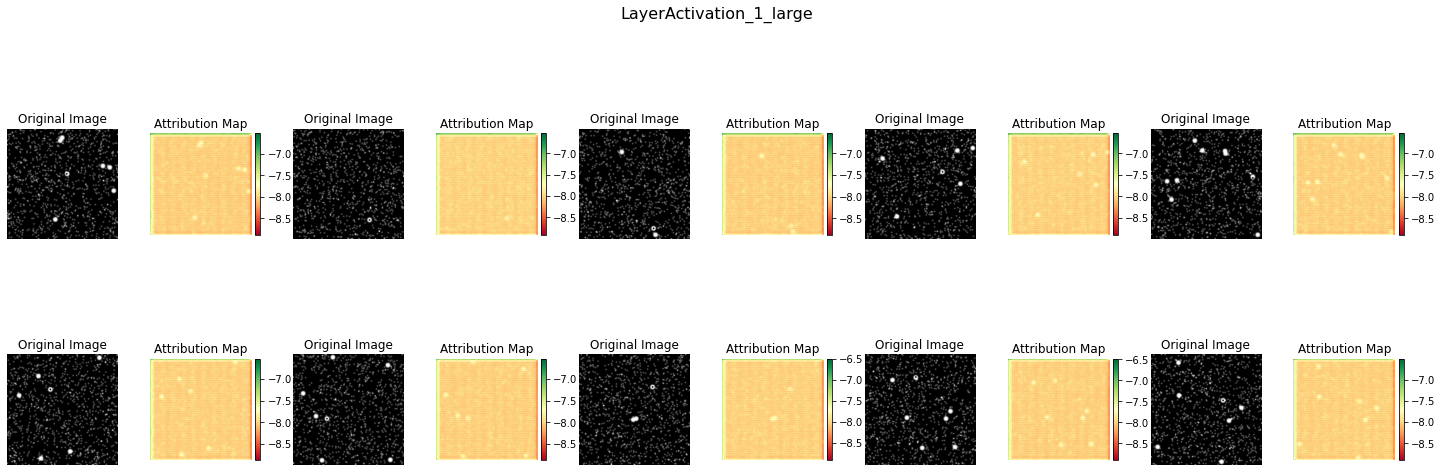

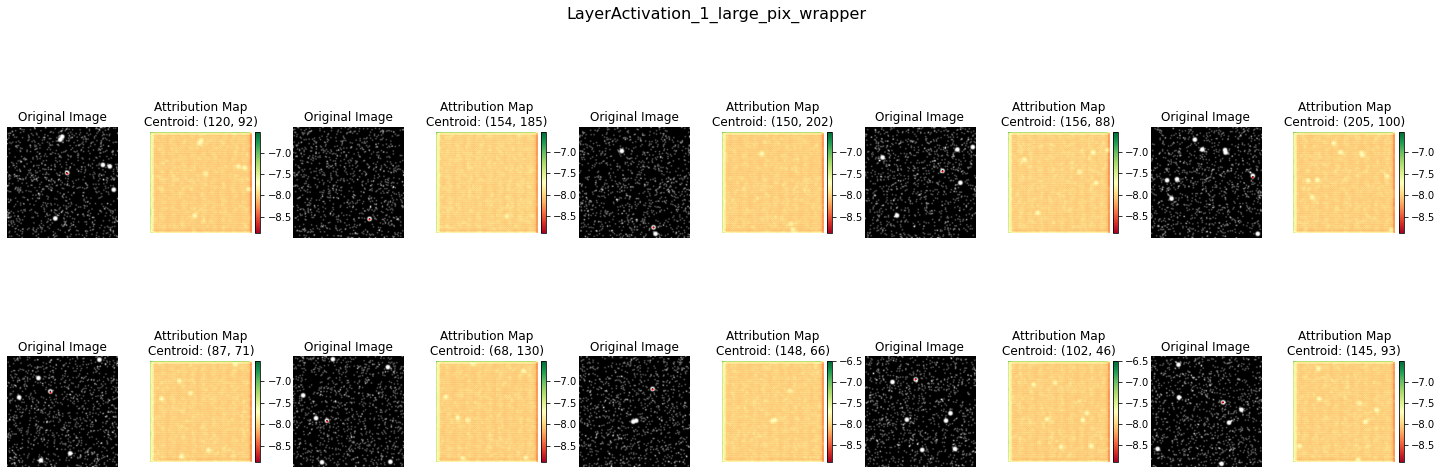

In [8]:
# Usage
attributions = seg_attr.compute_attributions('LayerActivation', 
                                             model.final, 
                                             tgt=target)
seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}LayerActivation_{target}_{dataset_type}",
                           title=f"LayerActivation_{target}_{dataset_type}") #method_target

attributions_pix = seg_attr.compute_attributions('LayerActivation', 
                                             model.final, 
                                             tgt=target,
                                             wrapper_type="pix")
seg_attr.plot_attributions(attributions_pix, 
                           wrapper_type="pix",
                           save_path=f"{path}LayerActivation_{target}_{dataset_type}_pix_wrapper",
                           title=f"LayerActivation_{target}_{dataset_type}_pix_wrapper") #method_target

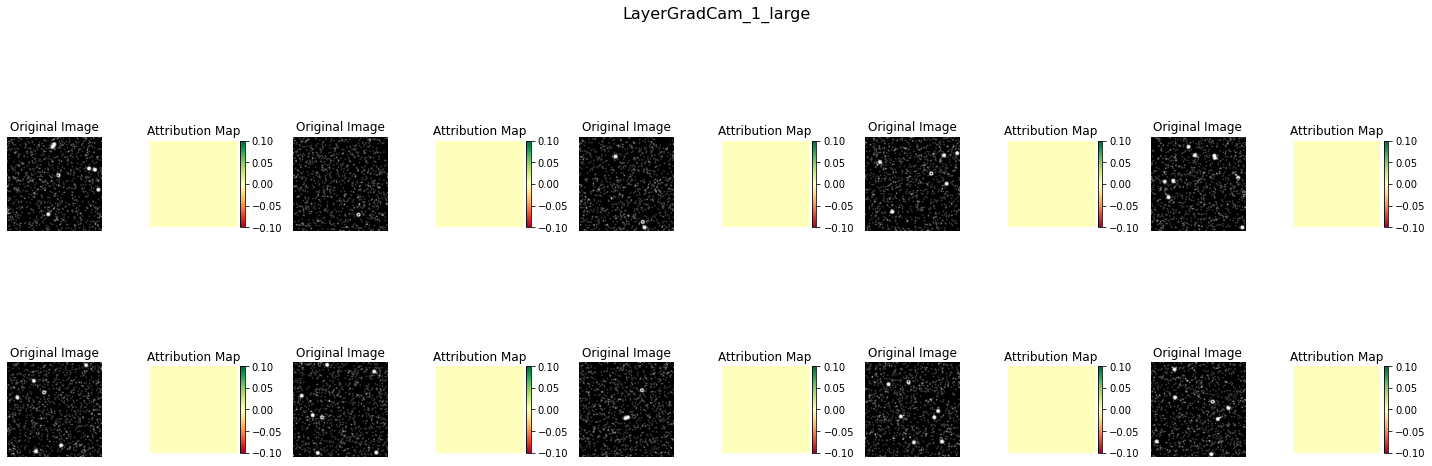

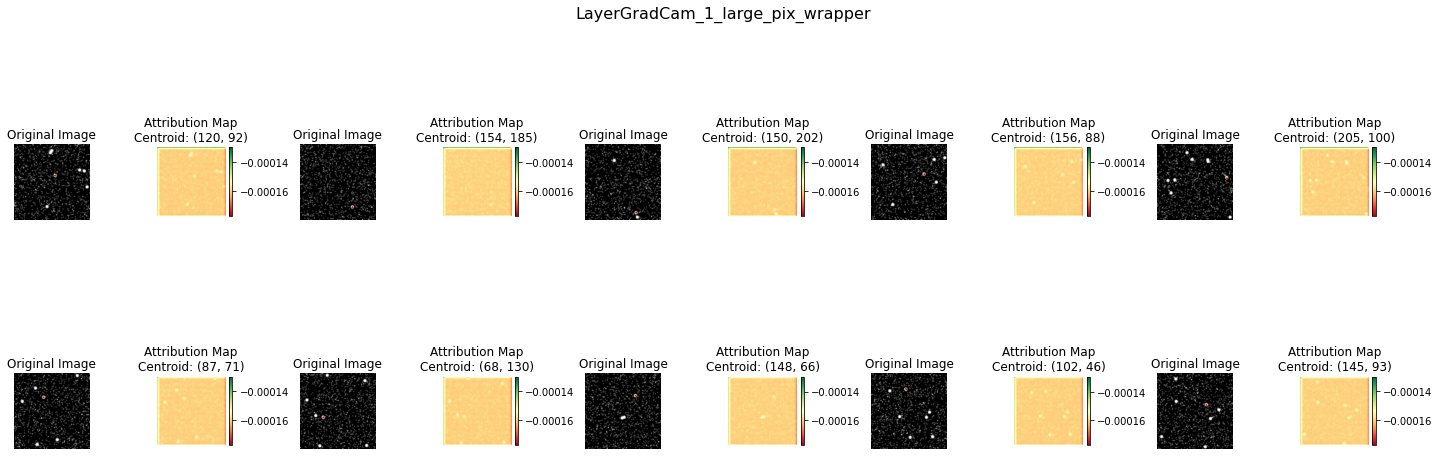

In [9]:
attributions = seg_attr.compute_attributions('LayerGradCam', 
                                             model.final, 
                                             tgt=1)
seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}LayerGradCam_{target}_{dataset_type}",
                           title=f"LayerGradCam_{target}_{dataset_type}") #method_target

attributions_pix = seg_attr.compute_attributions('LayerGradCam', 
                                             model.final, 
                                             tgt=1,
                                             wrapper_type="pix")
seg_attr.plot_attributions(attributions_pix, 
                           wrapper_type="pix",
                           save_path=f"{path}LayerGradCam_{target}_{dataset_type}_pix_wrapper",
                           title=f"LayerGradCam_{target}_{dataset_type}_pix_wrapper") #method_target

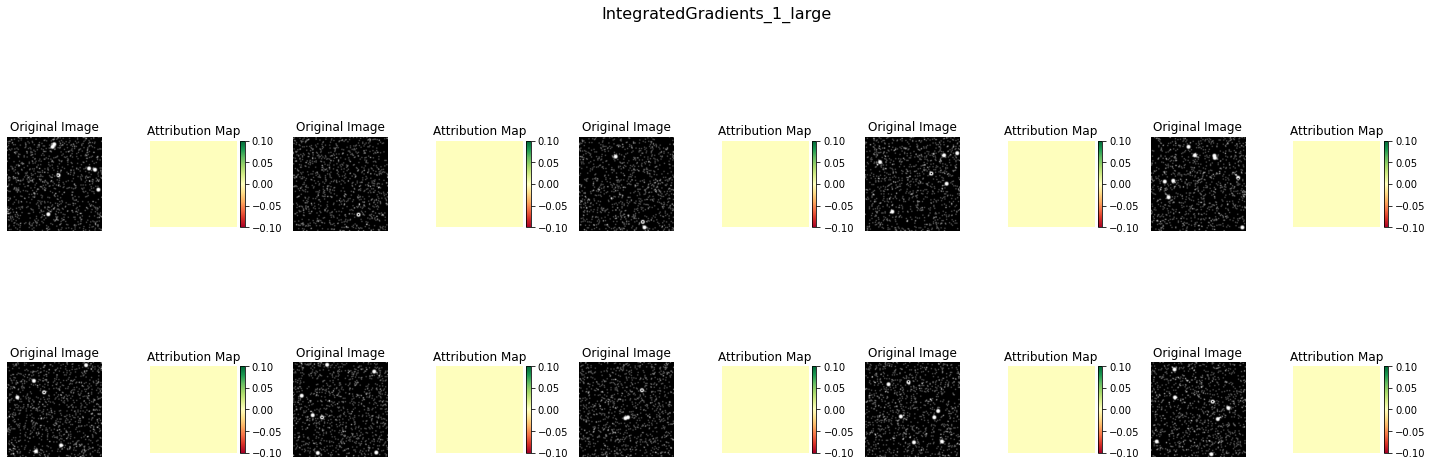

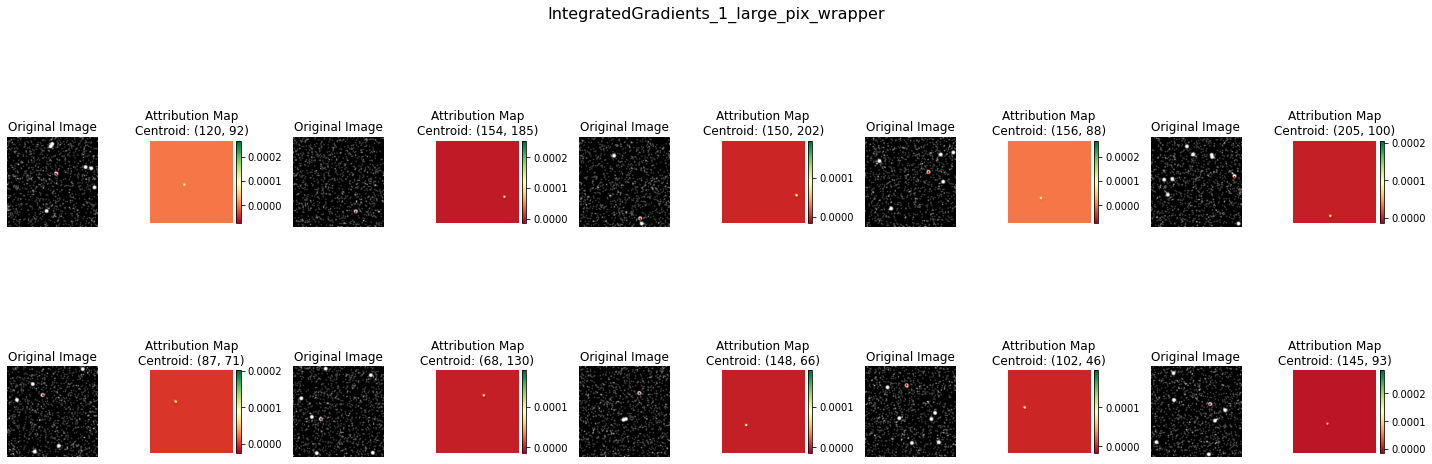

In [10]:
# Usage
attributions = seg_attr.compute_attributions('IntegratedGradients', 
                                             model.final, 
                                             n_steps=20,
                                             tgt=1)
seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}IntegratedGradients_{target}_{dataset_type}",
                           title=f"IntegratedGradients_{target}_{dataset_type}") #method_target

attributions_pix = seg_attr.compute_attributions('IntegratedGradients', 
                                             model.final,
                                             n_steps=20, 
                                             tgt=1,
                                             wrapper_type="pix")
seg_attr.plot_attributions(attributions_pix, 
                           wrapper_type="pix",
                           save_path=f"{path}IntegratedGradients_{target}_{dataset_type}_pix_wrapper",
                           title=f"IntegratedGradients_{target}_{dataset_type}_pix_wrapper") #method_target

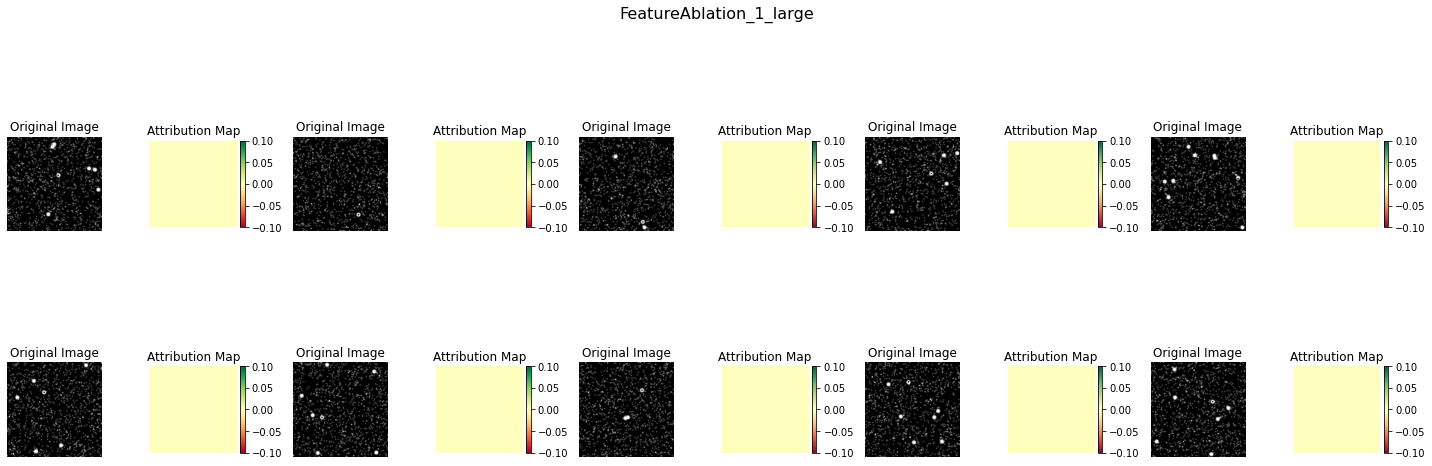

In [11]:
# Usage
attributions = seg_attr.compute_attributions('FeatureAblation', 
                                             model.final, 
                                             tgt=1)
seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}FeatureAblation_{target}_{dataset_type}",
                           title=f"FeatureAblation_{target}_{dataset_type}") #method_target

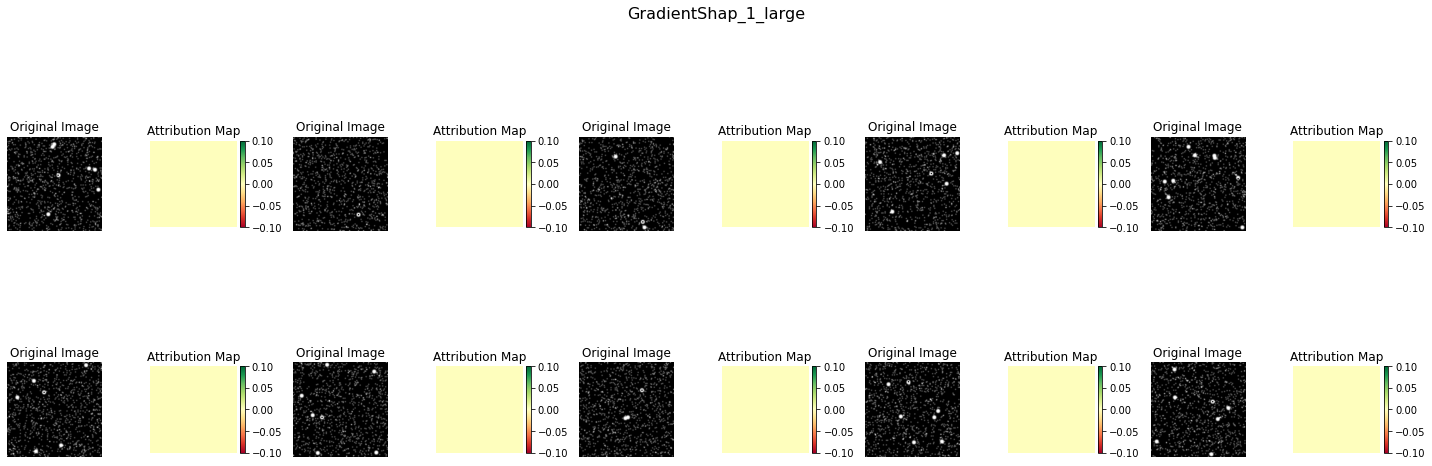

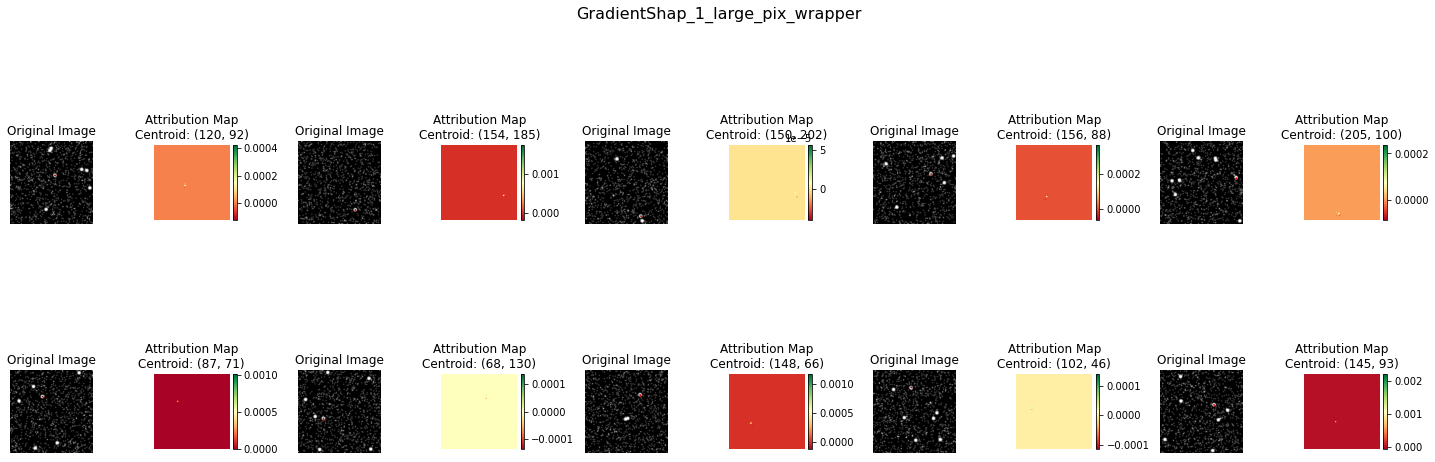

In [12]:
# Usage
attributions = seg_attr.compute_attributions('GradientShap', 
                                             model.final, 
                                             tgt=1)
seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}GradientShap_{target}_{dataset_type}",
                           title=f"GradientShap_{target}_{dataset_type}") #method_target

attributions_pix = seg_attr.compute_attributions('GradientShap', 
                                             model.final,
                                             tgt=1,
                                             wrapper_type="pix")
seg_attr.plot_attributions(attributions_pix, 
                           wrapper_type="pix",
                           save_path=f"{path}GradientShap_{target}_{dataset_type}_pix_wrapper",
                           title=f"GradientShap_{target}_{dataset_type}_pix_wrapper") #method_target